# Introduction
---
This notebook will focus on utilizing time-series forecasting techniques on [this](https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3/data) dataset from the San Francisco Fire Department. The goal is to predict the occurrence of fire-related calls, enabling the Fire Department to keep their staffing levels optimized, their resources correctly allocated and ultimately reduce the chances of public casualty.

We'll cover the following sections:
- EDA (Exploratory Data Analysis)
- Feature Engineering
- Machine Learning
- Future Prediction
- Summary 
- Conclusion

Through these sections, we aim to uncover patterns, engineer relevant features, build predictive models, and analyze their effectiveness in forecasting fire-related calls.

## First look

Let's start by importing most of the necessary packages and reading-in our data.

In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import holidays

In [2]:
#Reading in the dataset. 
#Forcing the function to parse the columns 19,20 and 25 as string values.
df = pd.read_csv('/Users/danielanderson/Documents/Portfolio/'\
                 'Time_Series/fire-calls-truncated-comma-no-spaces.csv',
                dtype = {19: str,
                         20: str,
                         25: str}
                )

^

Hitting slight issues already! It looks like some of the data isn't consistently formatted. We've had to force these columns to 'string' ('object' in Pandas) values in order to get the function to read-in the data. But not to worry, we'll have a look at these columns first in our EDA.

For now, let's get a brief overview of the datatypes and the timescale.

In [3]:
#Let's use df.info() to check our data-types and to see if there's 
#any NULL values. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240613 entries, 0 to 240612
Data columns (total 34 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Call_Number                           240613 non-null  int64  
 1   Unit_ID                               240613 non-null  object 
 2   Incident_Number                       240613 non-null  int64  
 3   Call_Type                             240613 non-null  object 
 4   Call_Date                             240613 non-null  object 
 5   Watch_Date                            240613 non-null  object 
 6   Received_DtTm                         240613 non-null  object 
 7   Entry_DtTm                            240613 non-null  object 
 8   Dispatch_DtTm                         240613 non-null  object 
 9   Response_DtTm                         220441 non-null  object 
 10  On_Scene_DtTm                         185288 non-null  object 
 11  

In [4]:
#Finding the first day, last day and difference in days.  
first_day = pd.to_datetime(df['Call_Date'], format = '%m/%d/%y').min()
last_day =  pd.to_datetime(df['Call_Date'], format = '%m/%d/%y').max()
total_time = last_day - first_day

print(f'First day: {first_day}')
print(f'Last day:  {last_day}')
print(f'The data spans {total_time.days} days.')

First day: 2000-04-12 00:00:00
Last day:  2018-11-06 00:00:00
The data spans 6782 days.


^

Great, our data starts just after the year 2000 and continues almost all the way to 2019. Giving us just over 18 and a half years of data to play with totaling 6782 days.

Looking at `df.info()` we can see that in our 240,613 rows, there's a fair amount of NULL values, which *may* or may not affect our investigation (I suggest that most of these NULL values will be inconsequential).

Ok, let's have a closer look at some of the insights our dataset holds.

# Step 1: Exploratory Data Analysis
---

Here, before changing any data or feature engineering, we'll delve into some of the trends within the dataset.

Let's start by having a quick look at the three columns which we had to change to 'string' values.

In [5]:
#Let's see how they look.
df[df.columns[[19, 20,25]]].tail()

,Station_Area,Box,Call_Type_Group
240608,10,4262,Non Life-threatening
240609,42,6345,Non Life-threatening
240610,3,1546,Potentially Life-Threatening
240611,21,4142,Non Life-threatening
240612,39,8622,Potentially Life-Threatening


^

It seems like they should be: int, int, string; respectively. I imagine that there's some random letters in the *int* columns and vice versa. So let's loop over these columns to extract anything that's not 100% what it should be. 

In [6]:
# # Checking over the 'Station_Area' column.
station_area_non_nums = []
for entry in df['Station_Area'].unique():
    try:
        float(entry)
    except:
        station_area_non_nums.append(entry)

# # Checking over the 'Box' column.
box_non_nums = []
for entry in df['Box'].unique():
    try:
        float(entry)
    except:
        box_non_nums.append(entry)

# # Checking over the 'Call_Type_Group' column
call_non_str = []
for entry in df['Call_Type_Group'].unique():
    if not isinstance(entry, str): 
        call_non_str.append(entry)
  
    
print(f'Anomalous entires "Station Area" {station_area_non_nums}')
print(f'Anomalous entires "Box"          {box_non_nums}')
print(f'Anomalous entires "Call Type"    {call_non_str}')

Anomalous entires "Station Area" ['A1', 'A3', 'A2']
Anomalous entires "Box"          ['AI02']
Anomalous entires "Call Type"    [nan]


^

Well here's the explanation for why the `read_csv()` function was having trouble categorizing these columns. 'Station_Area' and 'Box' are mainly intergers with a few instances of string values hidden. Whereas, since 'Call_Type_Group' contains NULL values, the function tried to convert the NULL values to NaNs (not a number), which are stored as a kind of 'float' value using NumPy, and because Pandas uses NumPy in the background, an error was raised and we had to specify that we wanted string values. 

With that out of the way, we can start to have a look at some of the date-trends in the dataset. We don't want to change anything right now, but we **will** convert the 'Received_DtTm' into date-time format and replace the index with it.

In [7]:
#Converting the column to standarised Date-Time format.
df['Received_DtTm'] = pd.to_datetime(df['Received_DtTm'],
                                     format = '%m/%d/%y %H:%M')

#Changing the index.
df.set_index('Received_DtTm', inplace = True)

#Sorting by date.
df.sort_index(inplace = True)

#Viewing the dataframe.
df.head()

,Call_Number,Unit_ID,Incident_Number,Call_Type,Call_Date,Watch_Date,Entry_DtTm,Dispatch_DtTm,Response_DtTm,On_Scene_DtTm,...,ALS_Unit,Call_Type_Group,Number_of_Alarms,Unit_Type,Unit_sequence_in_call_dispatch,Fire_Prevention_District,Supervisor_District,Neighborhooods_-_Analysis_Boundaries,Location,RowID
Received_DtTm,,,,,,,,,,,,,,,,,,,,,
2000-04-12 21:27:00,1030118,E08,30625,Medical Incident,4/12/00,4/12/00,4/12/00 21:28,4/12/00 21:29,4/12/00 21:31,4/12/00 21:32,...,False,NaN,1,ENGINE,1.0,3.0,6.0,NaN,"(37.7750268633971, -122.392346204303)",001030118-E08
2000-04-12 21:30:00,1030120,T13,30627,Alarms,4/12/00,4/12/00,4/12/00 21:30,4/12/00 21:31,4/12/00 21:37,NaN,...,False,NaN,1,TRUCK,3.0,1.0,3.0,Chinatown,"(37.7942116655012, -122.402644729189)",001030120-T13
2000-04-12 21:31:00,1030122,M18,30630,Medical Incident,4/12/00,4/12/00,4/12/00 21:33,4/12/00 21:34,4/12/00 21:35,4/12/00 21:45,...,False,NaN,1,MEDIC,1.0,8.0,4.0,Sunset/Parkside,"(37.763482287794, -122.477678638767)",001030122-M18
2000-04-12 22:05:00,1030138,M03,30646,Medical Incident,4/12/00,4/12/00,4/12/00 22:06,4/12/00 22:07,4/12/00 22:07,4/12/00 22:11,...,True,NaN,1,MEDIC,2.0,2.0,6.0,South of Market,"(37.7762305177878, -122.414711004673)",001030138-M03
2000-04-12 22:43:00,1030154,M36,30662,Medical Incident,4/12/00,4/12/00,4/12/00 22:45,4/12/00 22:49,4/12/00 22:50,4/12/00 22:53,...,False,NaN,1,MEDIC,1.0,2.0,6.0,Mission,"(37.7741251002903, -122.418810211803)",001030154-M36


^

Ok, let's have a look at how the amount of calls looks on a few different time-scales: Full period, Yearly, Monthly, Weekly.

In [8]:
#Let's create a new dataframe with just the date and the
#count of calls.

#We'll group by the date (since we're going to focus
#on day-trends) and count the RowIDs for each day.
df2 = df.groupby(df.index.date).agg(['count'])['RowID']
df2.index = pd.to_datetime(df2.index)

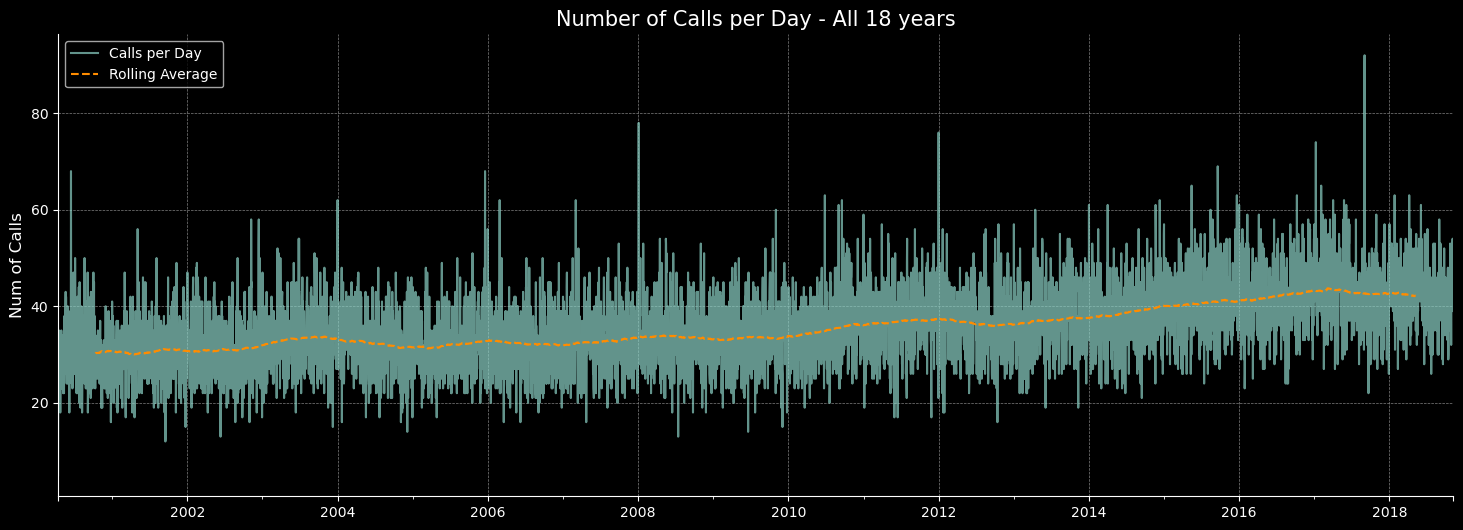

In [9]:
#Setting the dark styling, since I prefer that.
plt.style.use('dark_background')

#Plotting ALL of the data. 
df2['count'].plot(figsize = (18,6),
                 alpha = 0.7,
                 label = "Calls per Day"
                 )

#Getting a rolling average. 
rolling_average = df2['count'].rolling(window=365, center=True).mean()
rolling_average.plot(color='darkorange',
                     linestyle='--',
                     label='Rolling Average')

plt.legend()
plt.ylabel('Num of Calls', size = 12)
plt.title('Number of Calls per Day - All 18 years', size= 15)

#Getting rid of two boarders and making the gridlines look better. 
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

^

The only discernable trend from this view is the steady increase over the 18 years. We can see from the rolling average that the number of calls has increased, on average, from around 30 in 2000 to over 40 by 2018. An increase of 33%.

Let's look at the break-downs for an average year, month and week.

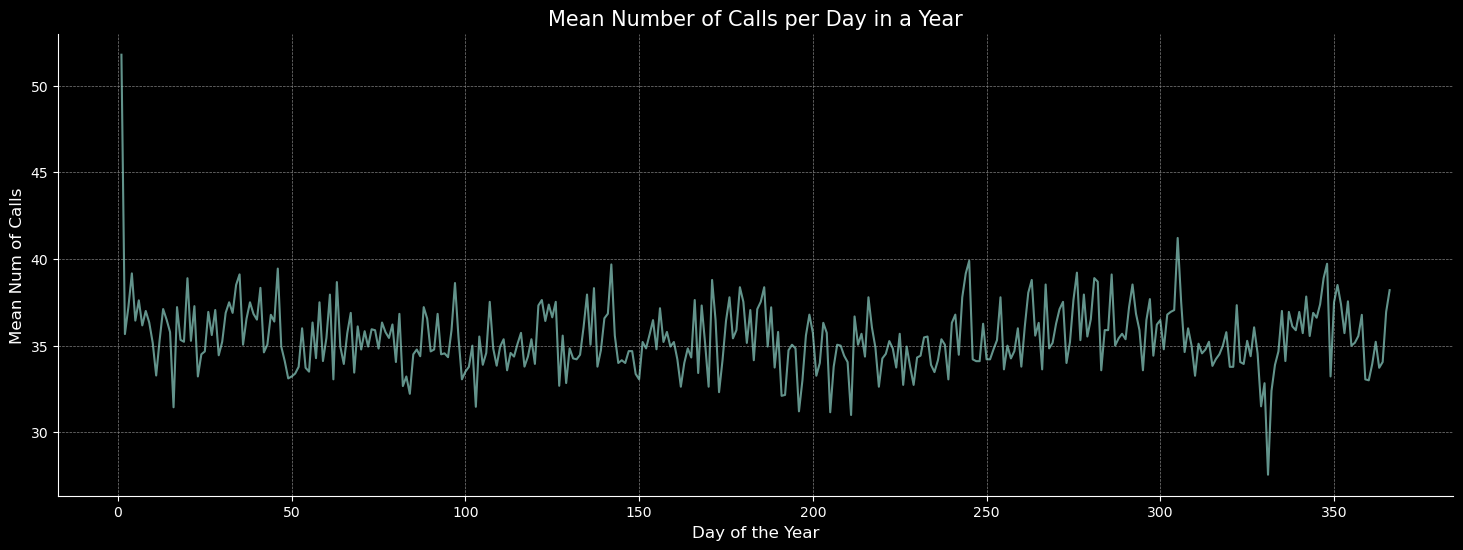

In [10]:
#Plotting the average data for any given year. 
df2.groupby(df2.index.dayofyear).agg(['mean'])\
    .plot(figsize = (18,6),
          alpha = 0.7,
          legend = False)

plt.ylabel('Mean Num of Calls', size = 12)
plt.xlabel('Day of the Year', size= 12)
plt.title('Mean Number of Calls per Day in a Year', size= 15)

#Styling. 
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

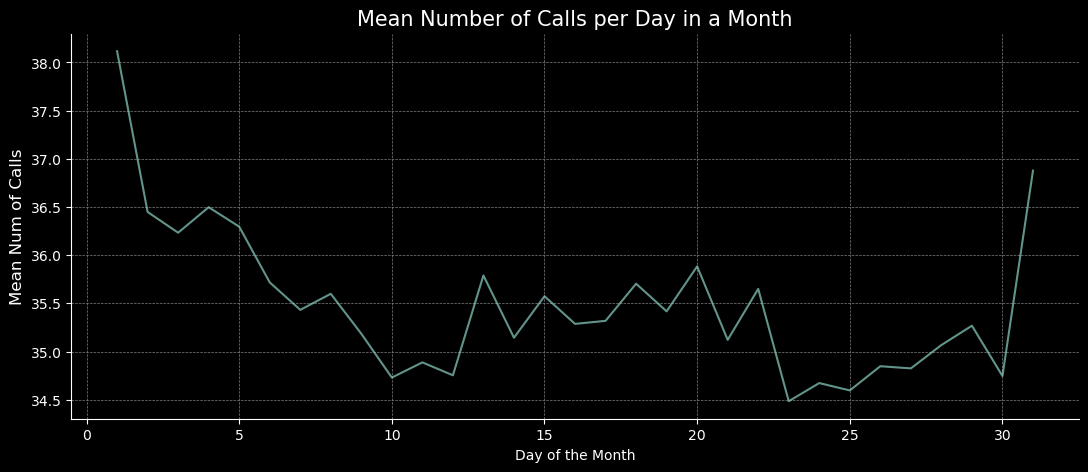

In [11]:
#Plotting the average data for any given month.
df2.groupby(df2.index.day).agg(['mean'])\
    .plot(figsize = (13,5),
          alpha = 0.7,
          legend = False
          )

plt.ylabel('Mean Num of Calls', size = 12)
plt.xlabel('Day of the Month')
plt.title('Mean Number of Calls per Day in a Month', size= 15)

#Styling. 
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

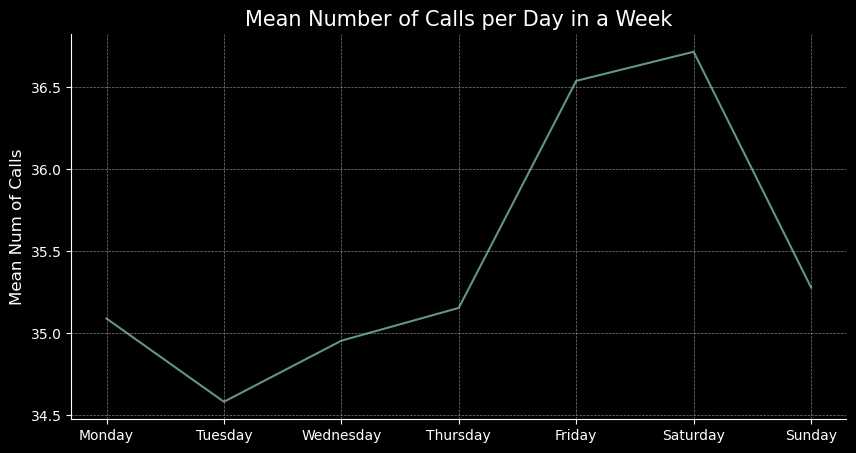

In [12]:
#Plotting the average data for any given week.
df2.groupby(df2.index.dayofweek).agg(['mean'])\
    .plot(figsize = (10,5),
          alpha = 0.7,
          legend = False
          )

plt.ylabel('Mean Num of Calls', size = 12)
plt.title('Mean Number of Calls per Day in a Week', size= 15)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday',
                      'Thursday', 'Friday', 'Saturday', 'Sunday'])

#Getting rid of two boarders and making the gridlines look better. 
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

^

The average yearly data has a curious peak around New Years Day, likely to be caused by the fireworks being set off after 00:00 to celebrate the new year. This trend can also be seen to a lesser extent in the 'All 18 years' plot.

The monthly and weekly plots are purposefully not evenly scaled along their y-axes to highlight changes, so it's worth bearing in mind that the differences aren't as large as they appear. The monthly data shows a total difference of 3.5 calls per day, with the most calls being towards the change of month. The weekly data shows a very slight increase in fire-related calls on Friday and Saturday but only by 1.5 calls per day; slightly less than I would have presumed, given that it *seems* that most events take place at the weekend, but this kind of gut-feeling can't be trusted, evidently.

Before we feature engineer our data and apply some predictive algorithms to it, we're going to have a look at some of the more 'important' columns, which may be positively affected by our predictions. Since we'll only be using the temporal data from the incoming calls to train the model, it may seem like all the other data is without purpose; but we can look at some of the columns to infer trends from our current knowledge on the predicted results.

Let's have a look at the probabilities found in some of our categorical columns.

In [13]:
#Checking 3 columns which may benefit from correct resource allocation.
print(df['Call_Type_Group'].value_counts(normalize=True))
print()
print(df['Unit_Type'].value_counts(normalize=True))
print()
print(df['ALS_Unit'].value_counts(normalize=True))

Call_Type_Group
Potentially Life-Threatening    0.484813
Alarm                           0.241206
Non Life-threatening            0.233502
Fire                            0.040479
Name: proportion, dtype: float64

Unit_Type
ENGINE            0.385798
MEDIC             0.308458
TRUCK             0.108037
CHIEF             0.073799
PRIVATE           0.061480
RESCUE CAPTAIN    0.034325
RESCUE SQUAD      0.018341
SUPPORT           0.004601
AIRPORT           0.004123
INVESTIGATION     0.001039
Name: proportion, dtype: float64

ALS_Unit
True     0.617743
False    0.382257
Name: proportion, dtype: float64


^

Interesting, it appears that more-or-less half of the calls are categorized as 'Potentially Life-Threatening'. 69% of units dispatched were either 'ENGINE' or 'MEDIC', and almost 62% of callouts involved an Advanced Life Support (ALS) unit, with personnel who are trained to provide a higher level of pre-hospital care.

All of these would be great things to know when optimizing staffing plans.

Now, let's split our data and engineer our features.

# Step 2: Feature Engineering
---

Since all of our features will be derived from the timestamp itself, there is minimal cleaning required for this dataset. Using other columns in our dataset for the Machine Learning algorithm poses a significant risk of data leakage—a crucial concept in Machine Learning and any data-related task. For example, if we were to include future information such as incident details or outcomes in our features, the model might unintentionally learn from information **not available** at the time of prediction, leading to inaccurate and over-optimistic results.


In this section we'll break our data into training and test sets, and we'll use our date-time data to engineer some features.

In [14]:
#We'll train on everything before 2015-11-18
train = df2.loc[df2.index < '2015-11-18']

#Our test data will be from 2015-11-18 onwards.
test = df2.loc[df2.index >= '2015-11-18']

#This gives us 3 years of test data.

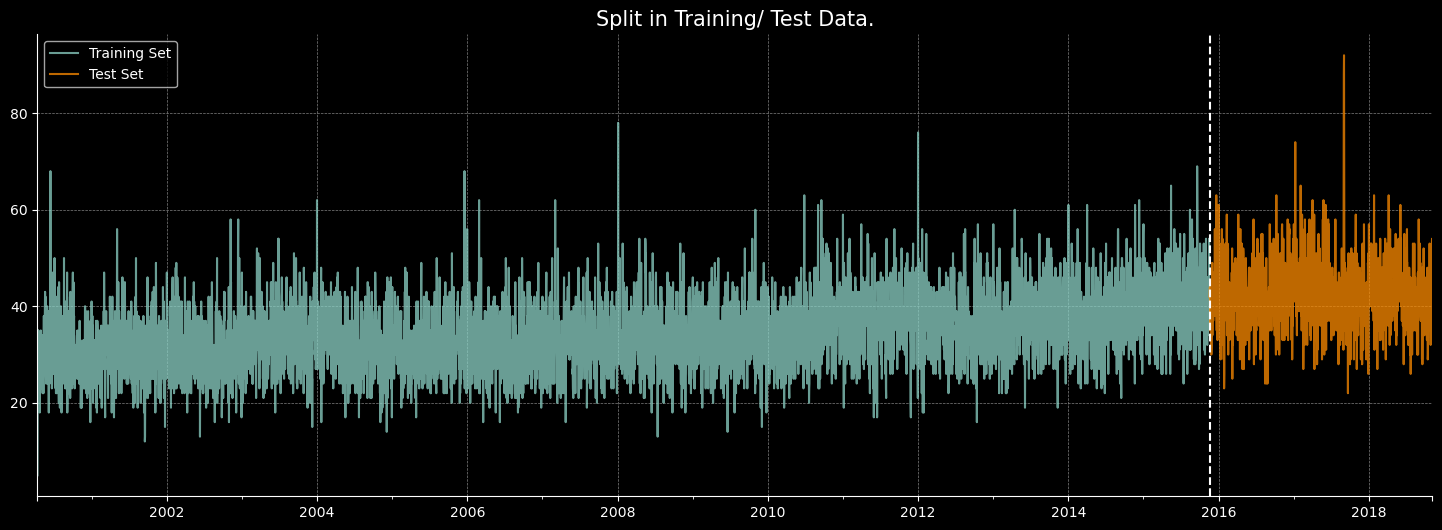

In [15]:
#Let's plot the split to check how it looks.
fig, ax = plt.subplots(figsize=(18, 6))
train.plot(ax=ax,
           label='Training Set',
           alpha = 0.75)
test.plot(ax=ax, 
          label='Test Set',
          color = 'darkorange',
          alpha = 0.75)

#Let's add a line demarcating the division. 
ax.axvline('2015-11-18', color='white', ls='--')

ax.set_title('Split in Training/ Test Data.', size = 15)
ax.legend(['Training Set', 'Test Set'])

#Usual styling.
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

^

We've chosen to give ourselves three years of test data to check out the model's performance and to leave fifteen and a half year's worth of data to train the model.

Now, let's write a quick function to add time-series features to our dataframes.

In [17]:
def apply_features(df):
    '''
    Add featues to given dataframe based on its 
    time-series index.
    
    df = dataframe with time-series index
    to add features to.
    '''
    df = df.copy()
    df['dayofweek']  = df.index.dayofweek
    df['weekofyear'] = df.index.isocalendar().week
    df['month']      = df.index.month
    df['dayofmonth'] = df.index.day
    df['quarter']    = df.index.quarter
    df['dayofyear']  = df.index.dayofyear
    df['year']       = df.index.year
    
    #Using trigonomatry to represent the cyclical
    #nature of months.
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    #And the cyclical nature of week days.
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    #Adding a boolean value feature for American public holidays.
    #Represented as 1 or 0.
    us_holidays = holidays.UnitedStates(
        years = range(df['year'].min(), df['year'].max() + 1)
    )
    
    df['public_holiday'] = (df.index.map(lambda x: x in us_holidays)).astype(int)
    
    return df

In [18]:
#Adding the new features to our training data.
train = apply_features(train)
train.rename(columns = {'count': 'Num_Calls'}, inplace = True)
train.head()

,Num_Calls,dayofweek,weekofyear,month,dayofmonth,quarter,dayofyear,year,month_sin,month_cos,dayofweek_sin,dayofweek_cos,public_holiday
2000-04-12,5,2,15,4,12,2,103,2000,0.866025,-0.5,0.974928,-0.222521,0
2000-04-13,24,3,15,4,13,2,104,2000,0.866025,-0.5,0.433884,-0.900969,0
2000-04-14,35,4,15,4,14,2,105,2000,0.866025,-0.5,-0.433884,-0.900969,0
2000-04-15,27,5,15,4,15,2,106,2000,0.866025,-0.5,-0.974928,-0.222521,0
2000-04-16,35,6,15,4,16,2,107,2000,0.866025,-0.5,-0.781831,0.623490,0


In [19]:
#Adding the features to our test data.
test = apply_features(test)
test.rename(columns = {'count': 'Num_Calls'}, inplace = True)
test.head()

,Num_Calls,dayofweek,weekofyear,month,dayofmonth,quarter,dayofyear,year,month_sin,month_cos,dayofweek_sin,dayofweek_cos,public_holiday
2015-11-18,42,2,47,11,18,4,322,2015,-0.5,0.866025,0.974928,-0.222521,0
2015-11-19,43,3,47,11,19,4,323,2015,-0.5,0.866025,0.433884,-0.900969,0
2015-11-20,44,4,47,11,20,4,324,2015,-0.5,0.866025,-0.433884,-0.900969,0
2015-11-21,35,5,47,11,21,4,325,2015,-0.5,0.866025,-0.974928,-0.222521,0
2015-11-22,42,6,47,11,22,4,326,2015,-0.5,0.866025,-0.781831,0.623490,0


^

Great, our dataframes have some extra features for the Machine Learning algorithms to try to learn. We've included month/ day-of-the-week cyclical features to try and capture their cyclical nature. Rather than December being simply represented as 12 and January as 1: which may suggest that December is 12 times larger, or that it's far away from January; we transform the day/ month into radians and use `np.sin` and `np.cos` to map these angles onto the 'unit' circle (a circle whose radius is 1).

We've also added a boolean column for the public holidays in the USA, just in case this adds value to the ML model. Let's have a look at the public holiday call data for our training/ test data.

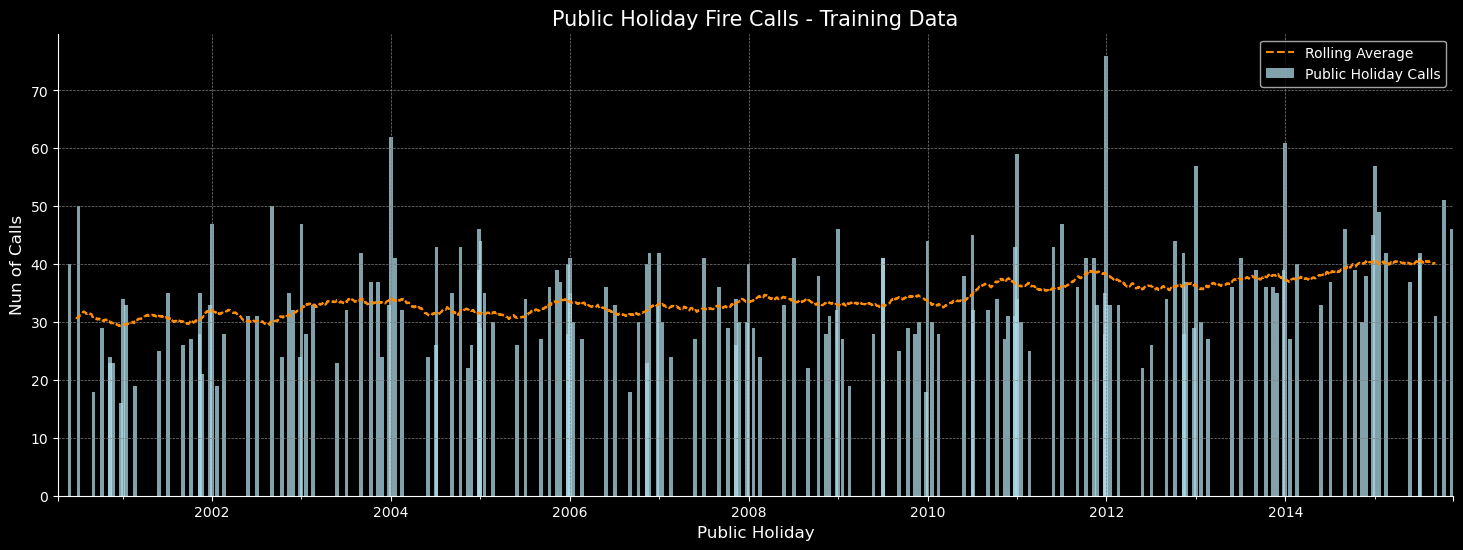

In [20]:
plt.figure(figsize = (18,6))
#Plotting Public Holiday Calls
plt.bar(train[train['public_holiday'] == 1].index,
        train[train['public_holiday'] == 1]['Num_Calls'],
        color = 'lightblue',
        width = 15,
        label = 'Public Holiday Calls',
        alpha = 0.75)

#Plotting the rolling average of our training data.
rolling_average2 = train['Num_Calls'].rolling(window=150, center=True).mean()
rolling_average2.plot(color='darkorange',
                     linestyle='--',
                     label='Rolling Average')

plt.title('Public Holiday Fire Calls - Training Data', size = 15)
plt.xlabel('Public Holiday', size = 12)
plt.ylabel('Nun of Calls', size = 12)
plt.legend()
#Usual styling.
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

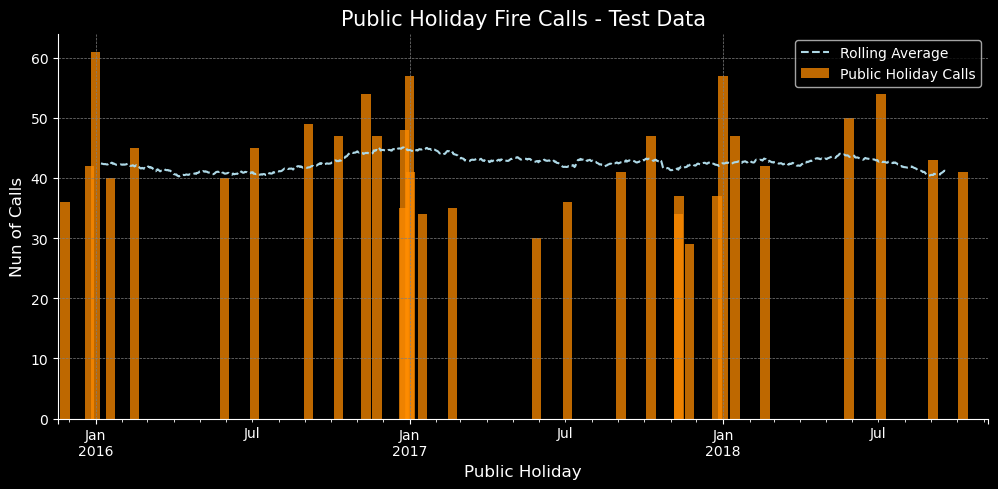

In [21]:
plt.figure(figsize = (12,5))
#Plotting Public Holiday Calls
plt.bar(test[test['public_holiday'] == 1].index,
        test[test['public_holiday'] == 1]['Num_Calls'],
        color = 'darkorange',
        width = 11,
        label = 'Public Holiday Calls',
        alpha = 0.75)

#Plotting the rolling average of our training data.
rolling_average3 = test['Num_Calls'].rolling(window=100, center=True).mean()
rolling_average3.plot(color='lightblue',
                     linestyle='--',
                     label='Rolling Average')

plt.title('Public Holiday Fire Calls - Test Data', size = 15)
plt.xlabel('Public Holiday', size = 12)
plt.ylabel('Nun of Calls', size = 12)
plt.legend()
#Usual styling.
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

^

We can see that there's some holidays which are well below the average and some which are above. Most notably, as mentioned earlier, New Years Eve/Day. But again, like the graphs shown in Step 1, there's no solid pattern.

Out of curiosity let's take a look at in a bit more detail New Years Eve/Day compared to the average number of calls.

In [22]:
#Getting the overall average.
overall_avg = df2['count'].mean()

#Finding the days New Years is celebrated.
New_Years = ((df2.index.month == 12) & (df2.index.day == 31)) \
          | ((df2.index.month == 1) & (df2.index.day == 1))

df_ny = df2[New_Years]

#Looping over the data to find the percent-change.
pairs = []
for i in range(len(df_ny['count']) - 1):
    if i % 2 != 1:
        pair = (df_ny['count'][i], df_ny['count'][i + 1])
        pairs.append(pair)

        
avg_pairs = []
for i, j in pairs:
    avg_pairs.append((i+j)/2)

    
ny_names = []
for i in range(18):
    if i < 9:
        date_name = f'200{i}/200{i+1}'
    elif i == 9:
        date_name = '2009/2010'
    else:
        date_name = f'20{i}/20{i+1}'
    ny_names.append(date_name)
    
print('New Year')
for year, avg in zip(ny_names, avg_pairs):
    print(f'{year} had {(avg / overall_avg - 1)*100:.2f}%  more calls')

New Year
2000/2001 had 5.71%  more calls
2001/2002 had 14.17%  more calls
2002/2003 had 14.17%  more calls
2003/2004 had 32.50%  more calls
2004/2005 had 2.90%  more calls
2005/2006 had 36.72%  more calls
2006/2007 had -6.97%  more calls
2007/2008 had 5.71%  more calls
2008/2009 had 26.86%  more calls
2009/2010 had 5.71%  more calls
2010/2011 had 31.09%  more calls
2011/2012 had 36.72%  more calls
2012/2013 had 31.09%  more calls
2013/2014 had 38.13%  more calls
2014/2015 had 57.87%  more calls
2015/2016 had 64.91%  more calls
2016/2017 had 38.13%  more calls
2017/2018 had 43.77%  more calls


^

Ok, so we can see here that the night of New Years Eve into the morning of New Years Day consistently has more fire-calls than the average, with one exception in 2006/2007. The number of calls is notably high after 2010, never dipping below 31% above average.

One last thing before we start making some predictions: let's create our X_test/ y_test data.

In [23]:
#Saving our features and target as variables.
features = ['dayofweek', 'weekofyear', 'month', 'dayofmonth',
       'quarter', 'dayofyear', 'year', 'month_sin', 'month_cos',
       'dayofweek_sin', 'dayofweek_cos', 'public_holiday']

target = 'Num_Calls'

#Creating the dataframes to put into the algorithms.
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# Step 3: Machine Learning
---
This report will use several Machine Learning methods to try and predict call volume. We'll use three different metrics to score our models: Mean Squared Error, Mean Absolute Error and R Squared Score.

Mean Squared Error is the average of the squared differences between predicted and actual values. It emphasizes larger errors due to the squaring process, making it sensitive to outliers. Mean Absolute Error is the average of the absolute differences between predicted and actual values. It provides a measure of the average magnitude of errors, regardless of their direction, and is less sensitive to outliers than Mean Squared Error. R Squared Score is a measure of how well the model's predictions match the variability in the actual data. It ranges from 0 to 1, with 1 indicating a perfect fit. It helps assess the proportion of variance in the target variable explained by the model.

We'll be looking at these models:
- Linear Regression
- Support Vector Regressor
- Random Forest Regressor
- Multi-Layer Perceptron
- Extreme Gradient Boosted Regressor

We'll start by importing our metrics and GridSearchCV, initializing a dataframe to hold the results, writing a function to add the results to the dataframe and creating scaled versions of our data.

In [24]:
#Importing metrics
from sklearn.metrics import mean_squared_error, r2_score, \
                            mean_absolute_error

#And GridSearch Cross-Fold Validation
from sklearn.model_selection import GridSearchCV

In [25]:
#Initialise our empty dataframe.
results_df = pd.DataFrame(columns = ['Model_Name','Mean_Squared', 'Mean_Absolute',
                                     'r2_score']
                         )
results_df

,Model_Name,Mean_Squared,Mean_Absolute,r2_score


In [26]:
#Creating a function to add data to dataframe.
def add_to_df(df, model,  name, scale = False):
    ''' 
    Adds the three metrics to the dataframe df.
    
    df = the dataframe to add to. 
    model = the trained model.
    name = the name of the model in the dataframe.
    scale = whether to use the scaled data or not.
    '''
    if scale == True:
        X = X_test_scaled
    else:
        X = X_test
    y_preds_ = model.predict(X)
    
    #Getting the scores from given model.
    meansqrd  = mean_squared_error(y_test, y_preds_)
    meanabs = mean_absolute_error(y_test, y_preds_)
    r2score    = r2_score(y_test, y_preds_)

    #Adding the data to the results_df.
    data = [{
            'Model_Name':    str(name),
            'Mean_Squared':  meansqrd,
            'Mean_Absolute': meanabs,
            'r2_score':      r2score
           }]
    
    temp_df = pd.DataFrame(data)
    df1 = pd.concat([df, temp_df], ignore_index = True)
    
    #Checking if there's any duplicates.
    df1 = df1.drop_duplicates() 
    
    return df1


In [27]:
#Creating scaled versions of the data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

--
## Linear Regression
--

Let's start by trying a Linear Regression model, since there's basically no hyperparameters to tune, we won't bother running a GridSearch on this model. 

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression()

In [30]:
results_df = add_to_df(results_df, lin_reg, 'Lin_Reg')
results_df

,Model_Name,Mean_Squared,Mean_Absolute,r2_score
0,Lin_Reg,60.4499,5.910494,-0.125702


^

These results aren't great, the negative R Squared score is telling us that the model doesn't fit the data well and that its predictions are worse than simply using the mean of the target variable. Let's define a function to look at our results visually.

In [31]:
def display_results(model, name, scaled = False):
    '''
    Will display a line plot of the results of the 
    given model compared to the actual values.
    
    model = the trained model to compare.
    name = name of model.
    scaled = to used the scaled data or not.
    '''
    #Use the scaled data if chosen.
    if scaled == True:
        X = X_test_scaled
    else:
        X = X_test
        
    #Adding the results to the test dataframe.
    test[f'{name}'] = model.predict(X)

    #Plotting the results.
    plt.figure(figsize = (18,6))
    test['Num_Calls'].plot(label = 'Actual Values',
                           alpha = 0.75)

    test[f'{name}'].plot(label = 'Predicted values',
                              alpha = 0.75,
                              color = 'darkorange')

    plt.legend()
    plt.title(f'{name} - Predictions', size = 15)
    plt.ylabel('Nun of Calls', size = 12)
    
    #Usual styling.
    ax = plt.gca()
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
    ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.show()

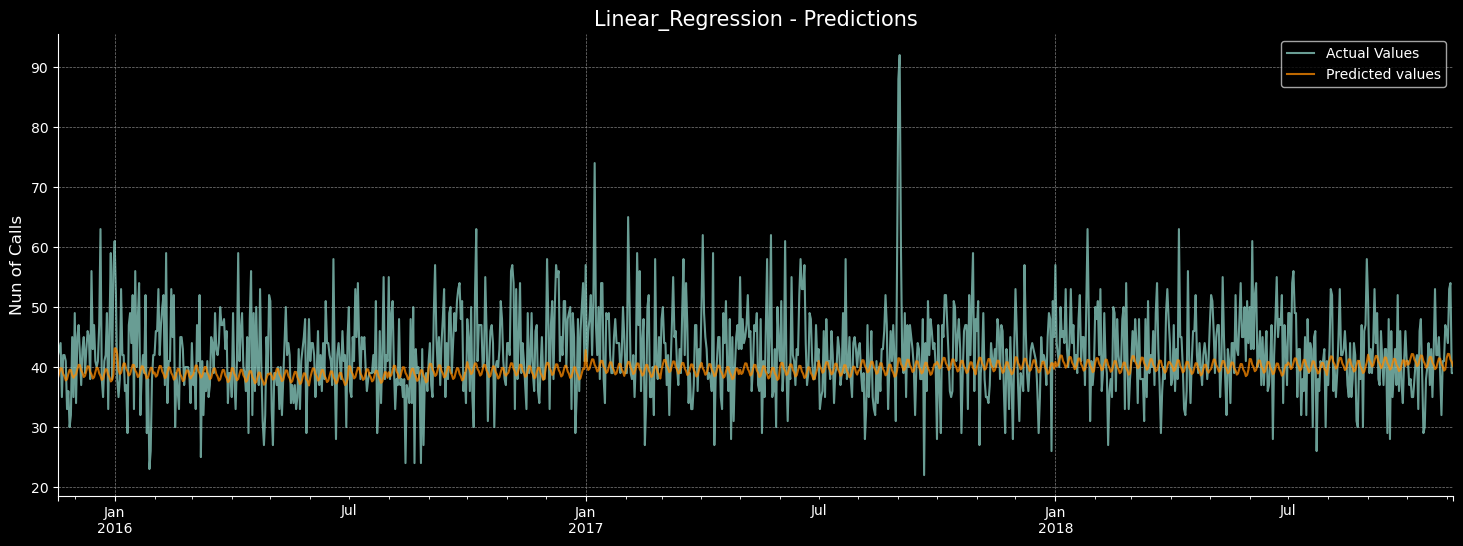

In [32]:
display_results(lin_reg, 'Linear_Regression')

^

We can see here that the model is more or less predicting the mean value throughout. These results are suspiciously poor, but let's continue using some different regression techniques and discuss reasons for low scores at the end.

--
## Support Vector Regressor
--

Support Vector Machines, in our case a Support Vector Regressor (SVR), can be computationally intensive and since this investigation is being conducted locally on my computer, we'll have to take caution not to add too many hyperparameters into the Grid Search.

Let's start with the base model as always.

In [33]:
from sklearn.svm import SVR

svr = SVR()

svr.fit(X_train, y_train)

SVR()

In [34]:
results_df = add_to_df(results_df, svr, 'SVR')
results_df

,Model_Name,Mean_Squared,Mean_Absolute,r2_score
0,Lin_Reg,60.449900,5.910494,-0.125702
1,SVR,126.235778,9.197318,-1.350771


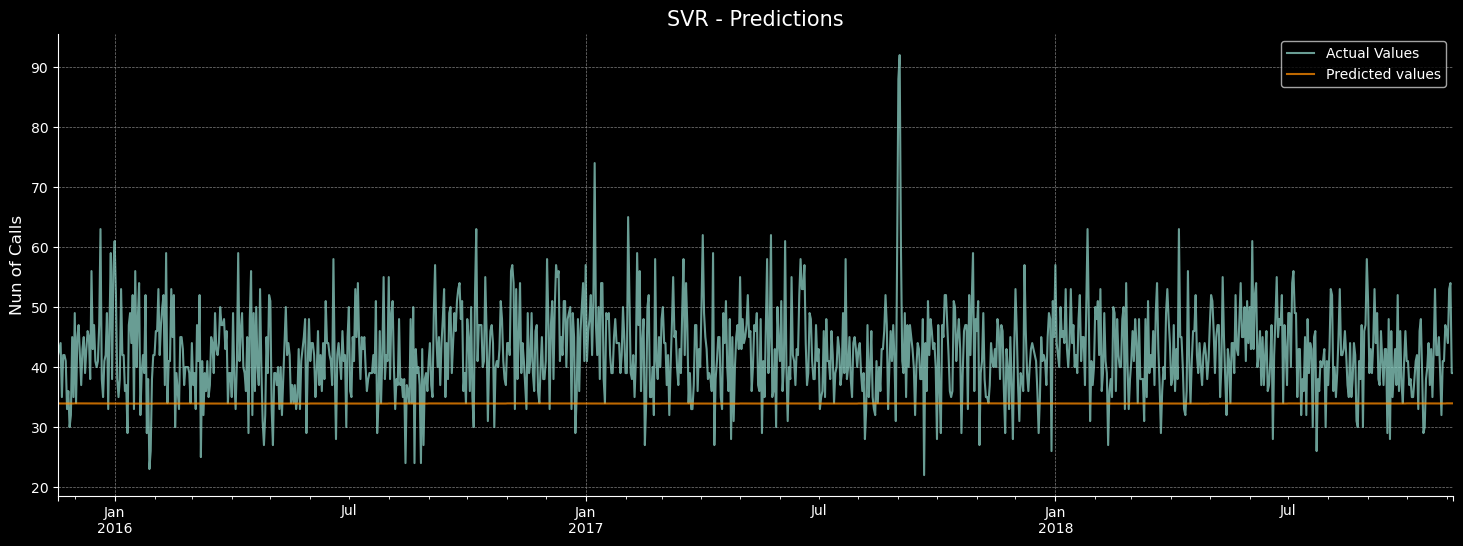

In [35]:
display_results(svr, 'SVR')

^

These results are twice as bad as the Linear Regression results, and the model is definitely just predicting the mean value.

Let's see how it fares with some hyperparameter tuning.

In [36]:
#Instantiating the model
svr2 = SVR()

#Adding hyperparameters.
param_grid_svr = {
    'C': [1],
    'kernel': ['poly'],
    'shrinking': [True],
    'tol': [1e-3],
    'epsilon': [0.1],
    'gamma': ['scale']
    
    
}
gs_svr = GridSearchCV(svr2, 
                       param_grid=param_grid_svr,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       n_jobs = -1)

#Fitting the scaled data.
gs_svr.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1], 'epsilon': [0.1], 'gamma': ['scale'],
                         'kernel': ['poly'], 'shrinking': [True],
                         'tol': [0.001]},
             scoring='neg_mean_squared_error')

In [37]:
results_df = add_to_df(results_df, gs_svr, 'SVR_TUNE_SCALED', scale = True )
results_df

,Model_Name,Mean_Squared,Mean_Absolute,r2_score
0,Lin_Reg,60.449900,5.910494,-0.125702
1,SVR,126.235778,9.197318,-1.350771
2,SVR_TUNE_SCALED,61.347450,5.969189,-0.142416


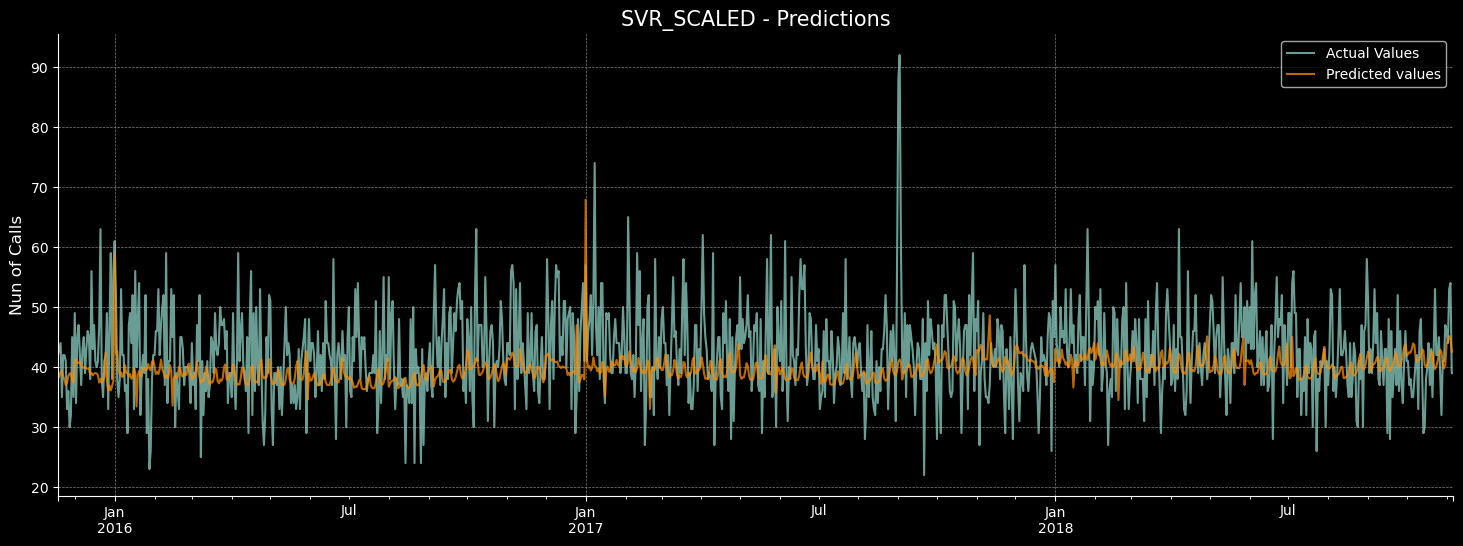

In [38]:
display_results(gs_svr, 'SVR_SCALED', scaled = True)

^

This model's performance is still poor, but it does seem to correctly infer that New Years would receive more calls. 

Many hyperparameters were looked at in order to tune the model:
- `'C': [0.1, 1, 3, 10],`
- `'kernel': ['linear', 'rbf', 'poly'],`
- `'gamma': [0.1, 1, 'auto', 'scale'],`
- `'epsilon': [0.1, 0.2, 0.5],`
- `'shrinking': [True, False],`
- `'tol': [1e-3, 1e-4, 1e-5]`

This was left to run overnight but didn't return any results as it crashed the computer. Upon further inspection and deduction, the computer was struggling to compute the `gamma` parameter with the unscaled data. This may have to do with the scale of the features and the sensitivity of the SVM (Support Vector Machine) model to feature scaling. A quick Google search told me that: Support Vector Machines, especially those with an RBF (Radial Basis Function) kernel like 'poly' and 'rbf', can be sensitive to the scale of input features. The 'gamma' parameter is a scaling factor in the RBF kernel, and its performance can be affected by the scale of the data.

After *a lot* of waiting, the scaled features were input into the algorithm; but in the end all but one of the best hyperparameters -`kernel`- were the same as the default settings anyway.

Lesson learned, on to the next technique.

--
## Random Forest Regressor
--

A fan favourite because of its intuitive design, a Random Forest Regressor is an ensemble machine learning model that builds a multitude of decision trees during training and outputs the average prediction of the individual trees for regression tasks.

Let's see how the base model performs and then we'll apply some hyperparameter tuning.

In [39]:
from sklearn.ensemble import RandomForestRegressor

#Trying a base model.
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

In [40]:
results_df = add_to_df(results_df, rf, 'Rand_Forest')
results_df

,Model_Name,Mean_Squared,Mean_Absolute,r2_score
0,Lin_Reg,60.449900,5.910494,-0.125702
1,SVR,126.235778,9.197318,-1.350771
2,SVR_TUNE_SCALED,61.347450,5.969189,-0.142416
3,Rand_Forest,62.932544,6.076802,-0.171934


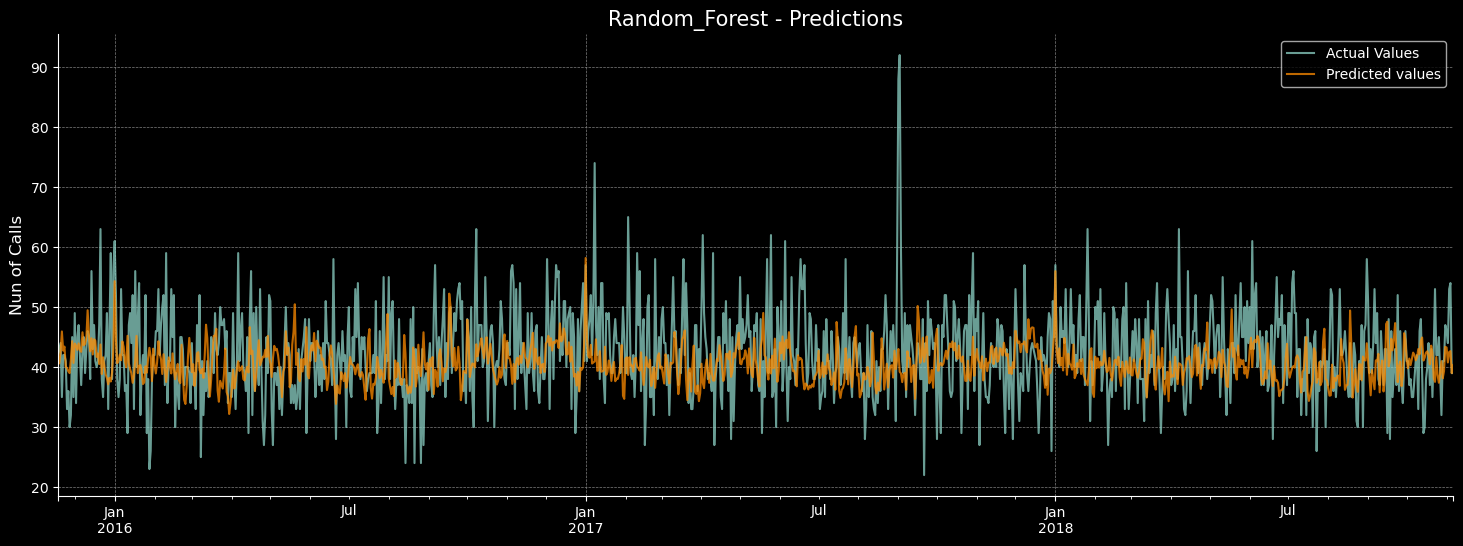

In [41]:
display_results(rf, 'Random_Forest')

^ 

These results are numerically poor, but visually we can see that there's more movement, it predicts a rise in calls on all three New Years in the test dataset.

Let's add a few hyperparameters to tune.

In [42]:
#Instantiating the model
rf2 = RandomForestRegressor()

#Adding hyperparameters.
param_grid_svr = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6,7,8],
    
}
gs_rf = GridSearchCV(rf2, 
                     param_grid=param_grid_svr,
                     scoring='neg_mean_squared_error',
                     cv=5,
                     n_jobs = -1)

#Fitting the scaled data.
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error')

In [43]:
results_df = add_to_df(results_df, gs_rf, 'Rand_Forest_TUNED')
results_df

,Model_Name,Mean_Squared,Mean_Absolute,r2_score
0,Lin_Reg,60.449900,5.910494,-0.125702
1,SVR,126.235778,9.197318,-1.350771
2,SVR_TUNE_SCALED,61.347450,5.969189,-0.142416
3,Rand_Forest,62.932544,6.076802,-0.171934
4,Rand_Forest_TUNED,57.628502,5.774133,-0.073162


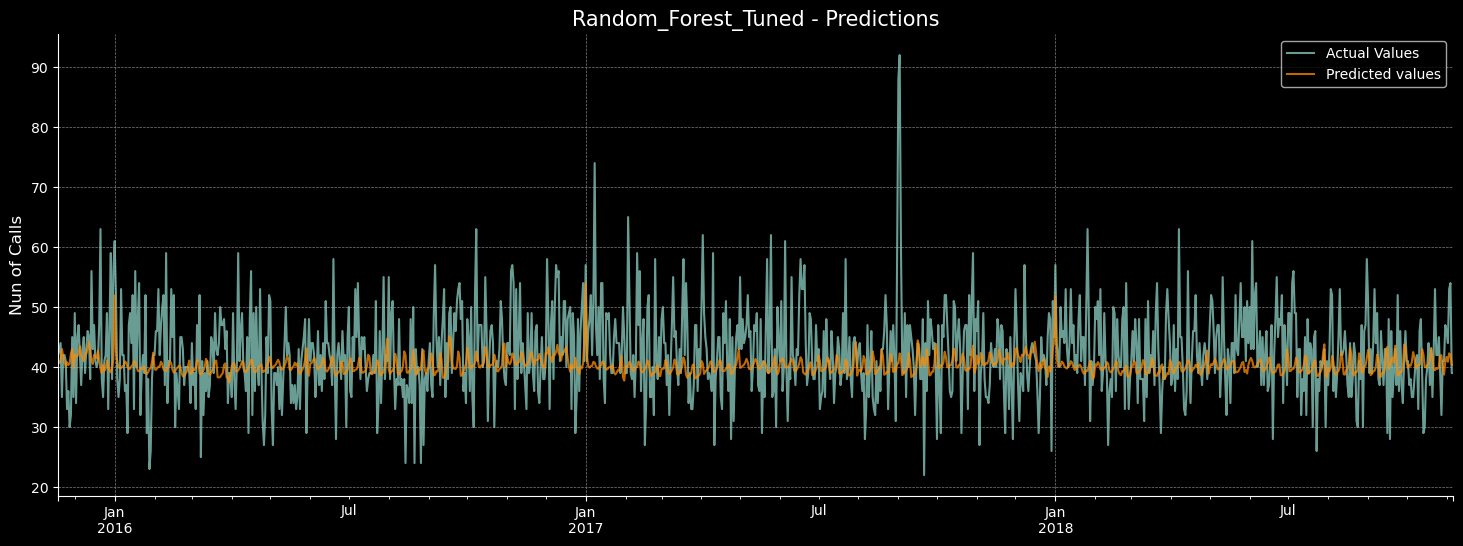

In [44]:
display_results(gs_rf, 'Random_Forest_Tuned')

^ 

These results are similar to the Support Vector Regressor, it clearly learns the New Years trend but then proceeds to more or less predict the mean value. It's also worth saying that more hyperparameters were searched over, but the algorithms were taking an inordinately long time to compute, so for the sake of repeatability in this notebook, the most effective ones were kept in the code.

Next, let's try something slightly different.

--
## Multi-Layer Perceptron
--

Perhaps one of the *cooler* names for a model, the Multi-Layer Perceptron Regressor is a neural-network-based algorithm. A neural network is a computational model inspired by the structure and function of the human brain. It consists of interconnected nodes, or artificial neurons, organized into layers. The layers typically include an input layer, one or more hidden layers, and an output layer.

In [45]:
from sklearn.neural_network import MLPRegressor

In [46]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50),
                             max_iter=1000,
                             random_state=42)

# Fit the model
mlp_regressor.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

In [47]:
results_df = add_to_df(results_df, mlp_regressor, 'MLP', scale = True)
results_df

,Model_Name,Mean_Squared,Mean_Absolute,r2_score
0,Lin_Reg,60.449900,5.910494,-0.125702
1,SVR,126.235778,9.197318,-1.350771
2,SVR_TUNE_SCALED,61.347450,5.969189,-0.142416
3,Rand_Forest,62.932544,6.076802,-0.171934
4,Rand_Forest_TUNED,57.628502,5.774133,-0.073162
5,MLP,54.383688,5.707679,-0.012737


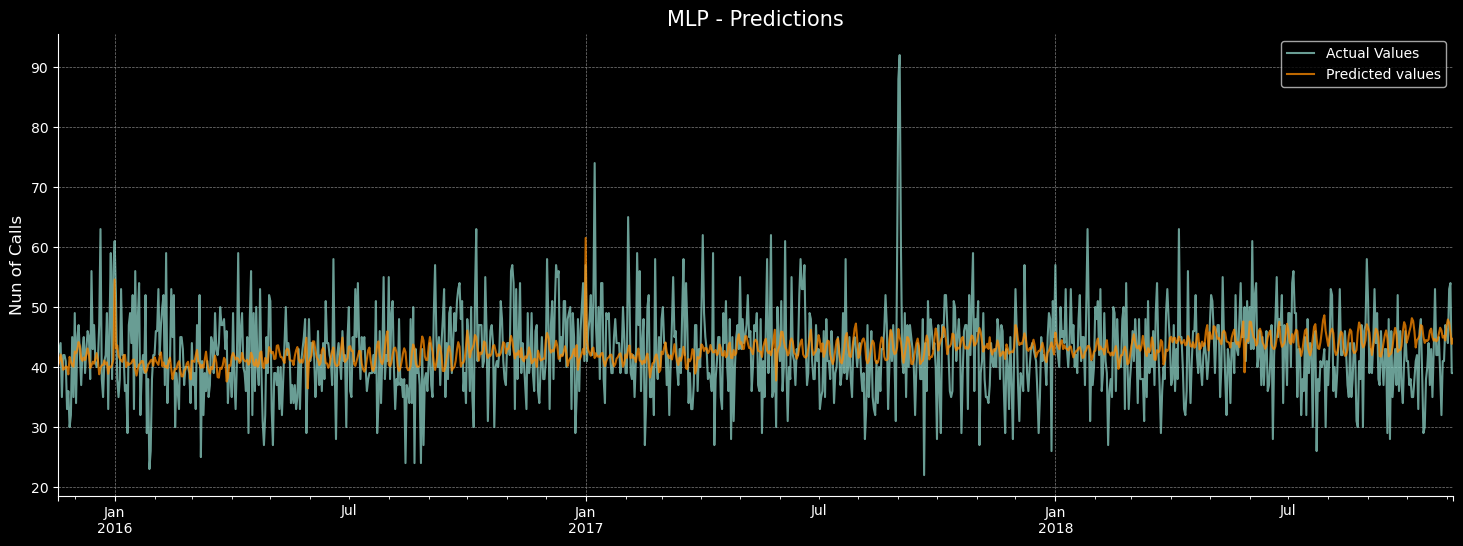

In [48]:
display_results(mlp_regressor, 'MLP', scaled = True)

^


We're not going to be using GridSearchCV here since neural networks are highly sensitive to their architecture and hyperparameters, and manual tuning or more advanced optimization techniques, such as random search, are often preferred for better control and customization.

Many different combinations of `hidden_layer_sizes` were tried, as well as almost all of the other tunable parameters, but in the end a simple model performed the best and overfit the least. 

The results here are the best yet but are still worse than simply predicting the mean value. Unlike all of the previous models the Multi-Layer Perceptron **does** appear to capture the steady rise in calls, but this doesn't seem to greatly improve its performance.

--
## XGBoost Regressor
--

In another project I've conducted, the eXtreme Gradient Boosted model was by far and away the best performing model; but this dataset seems to be too random for any of the Machine Learning models to predict. Let's see how the XGB Regressor manages this dataset. Starting with, as always, the base model.

In [49]:
from xgboost import XGBRegressor

In [50]:
#Instsantiate the base XGB model
XGBR = XGBRegressor().fit(X_train, y_train)

In [51]:
results_df = add_to_df(results_df, XGBR, 'XGBR')
results_df

,Model_Name,Mean_Squared,Mean_Absolute,r2_score
0,Lin_Reg,60.449900,5.910494,-0.125702
1,SVR,126.235778,9.197318,-1.350771
2,SVR_TUNE_SCALED,61.347450,5.969189,-0.142416
3,Rand_Forest,62.932544,6.076802,-0.171934
4,Rand_Forest_TUNED,57.628502,5.774133,-0.073162
5,MLP,54.383688,5.707679,-0.012737
6,XGBR,71.126339,6.449346,-0.324520


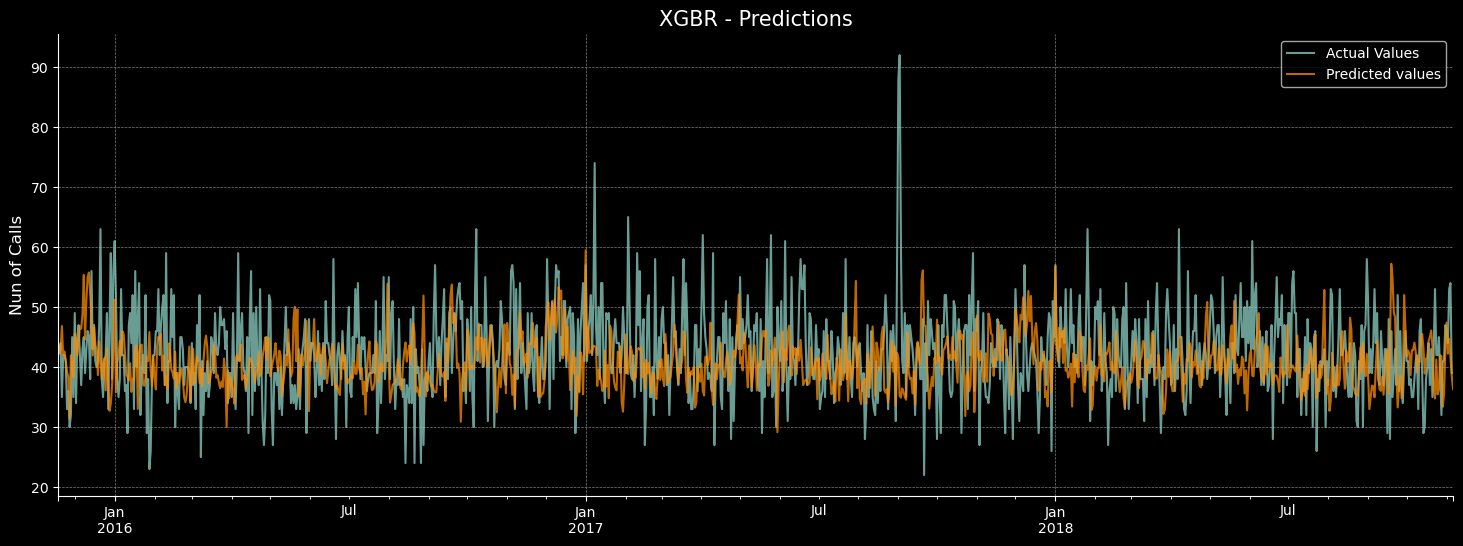

In [52]:
display_results(XGBR, 'XGBR')

^

These results are all over the place. It's clearly trying to predict *something*, but nothing useful. Let's see how it reacts to some hyperparameter tuning.

In [53]:
XGBR = XGBRegressor()


param_grid_XGBR = {
    'learning_rate': [0.01],
    'n_estimators': [600, 800, 1000],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.2]
    
}

gs_XGBR = GridSearchCV(XGBR, 
                       param_grid=param_grid_XGBR,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       n_jobs=-1)

gs_XGBR.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [3, 4],
                         'n_estimators': [600, 800, 1000],
                         'reg_alpha': [0, 0.1, 0.2],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [54]:
results_df = add_to_df(results_df, gs_XGBR, 'XGBR_TUNED')
results_df

,Model_Name,Mean_Squared,Mean_Absolute,r2_score
0,Lin_Reg,60.449900,5.910494,-0.125702
1,SVR,126.235778,9.197318,-1.350771
2,SVR_TUNE_SCALED,61.347450,5.969189,-0.142416
3,Rand_Forest,62.932544,6.076802,-0.171934
4,Rand_Forest_TUNED,57.628502,5.774133,-0.073162
5,MLP,54.383688,5.707679,-0.012737
6,XGBR,71.126339,6.449346,-0.324520
7,XGBR_TUNED,57.586888,5.779354,-0.072387


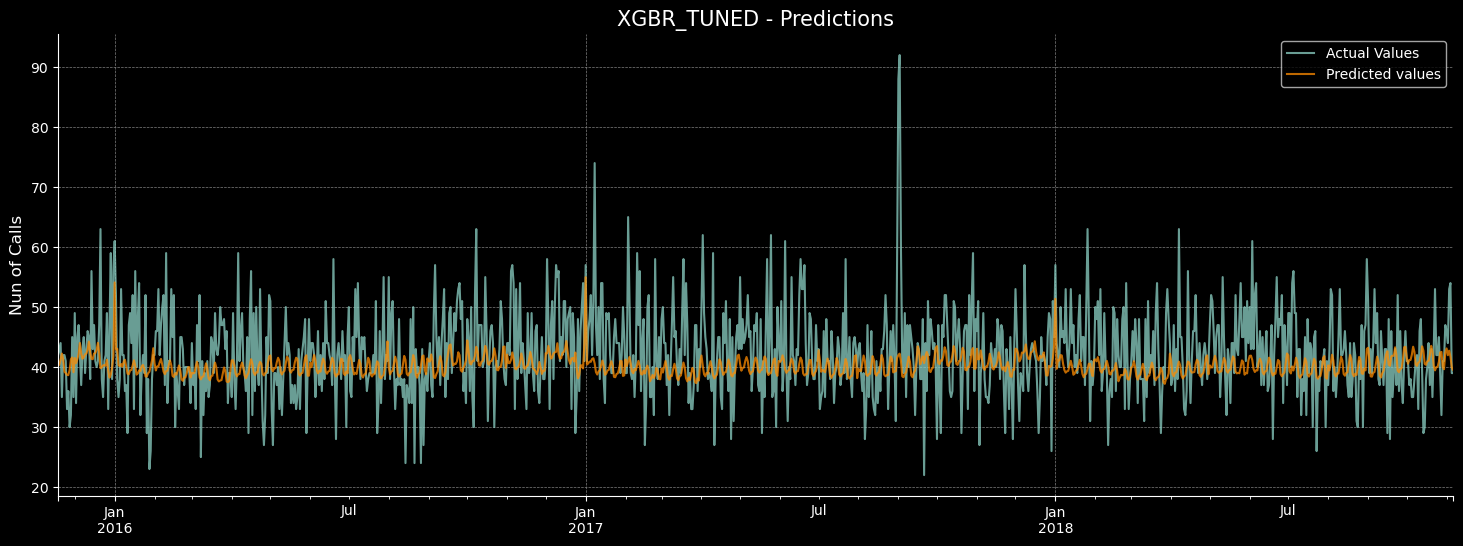

In [55]:
display_results(gs_XGBR, 'XGBR_TUNED')

^

These results are on par with the tuned Random Forest, which is to say, still poor; although it *is* predicting a rise for New Year and is certainly more regulated than the untuned XGB model.

Out of curiosity, let's see how it reacts to the scaled data.

In [56]:
XGBR = XGBRegressor()


param_grid_XGBR = {
    'learning_rate': [0.01],
    'n_estimators': [600, 800, 1000],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.2]
    
}

gs_XGBR_scaled = GridSearchCV(XGBR, 
                       param_grid=param_grid_XGBR,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       n_jobs=-1)

#Using the scaled data this time.
gs_XGBR_scaled.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [3, 4],
                         'n_estimators': [600, 800, 1000],
                         'reg_alpha': [0, 0.1, 0.2],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [57]:
results_df = add_to_df(results_df, gs_XGBR_scaled, 'XGBR_TUNED_SCALED', scale =True)
results_df

,Model_Name,Mean_Squared,Mean_Absolute,r2_score
0,Lin_Reg,60.449900,5.910494,-0.125702
1,SVR,126.235778,9.197318,-1.350771
2,SVR_TUNE_SCALED,61.347450,5.969189,-0.142416
3,Rand_Forest,62.932544,6.076802,-0.171934
4,Rand_Forest_TUNED,57.628502,5.774133,-0.073162
5,MLP,54.383688,5.707679,-0.012737
6,XGBR,71.126339,6.449346,-0.324520
7,XGBR_TUNED,57.586888,5.779354,-0.072387
8,XGBR_TUNED_SCALED,57.573539,5.777906,-0.072138


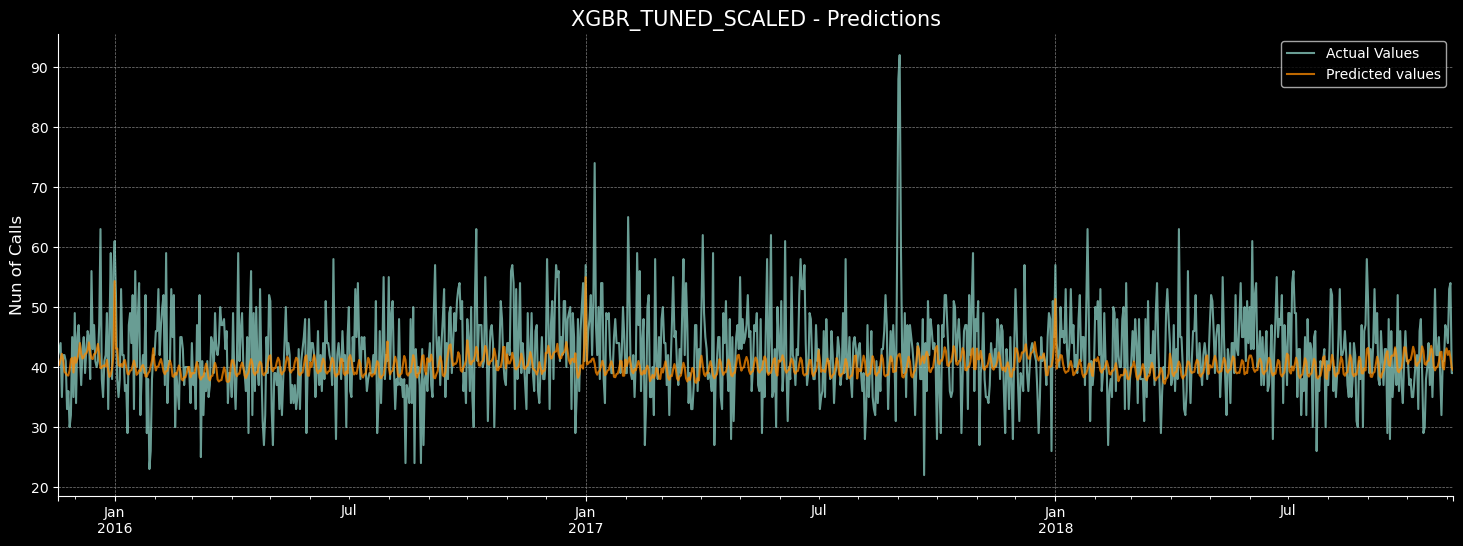

In [58]:
display_results(gs_XGBR_scaled, 'XGBR_TUNED_SCALED', scaled = True)

^

As we can see, the results with the scaled features are more or less the same. Disappointing, but sometimes things are very difficult to predict. 

# Step 4: Model Selection and Future Prediction
---
So now that we've seen that all of our models perform poorly, let's see what the predictions up to the year 2021 would look like - solely out of curiosity, of course. 

In [60]:
# Define the start and end dates.
start_date = dt.datetime.strptime('2018-11-07', '%Y-%m-%d')
end_date = dt.datetime.strptime('2020-12-31', '%Y-%m-%d')

# Define the step interval.
step = dt.timedelta(days=1)

# Generate the list of dates. 
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += step
    
#Create future dataframe.
df_future = pd.DataFrame(index = date_list)

#Converting the index from strings to datetime.
df_future.index = pd.to_datetime(df_future.index)

#Using our function from Step 2.
df_future = apply_features(df_future)
df_future.tail()

,dayofweek,weekofyear,month,dayofmonth,quarter,dayofyear,year,month_sin,month_cos,dayofweek_sin,dayofweek_cos,public_holiday
2020-12-27,6,52,12,27,4,362,2020,-2.449294e-16,1.0,-0.781831,0.623490,0
2020-12-28,0,53,12,28,4,363,2020,-2.449294e-16,1.0,0.000000,1.000000,0
2020-12-29,1,53,12,29,4,364,2020,-2.449294e-16,1.0,0.781831,0.623490,0
2020-12-30,2,53,12,30,4,365,2020,-2.449294e-16,1.0,0.974928,-0.222521,0
2020-12-31,3,53,12,31,4,366,2020,-2.449294e-16,1.0,0.433884,-0.900969,0


^

Here we've created a set of features for the model to try and predict, of course we don't have the actual data to compare it to, but we're just doing this out of curiosity.

We'll train our best model, the MLP regressor, on **all** of our data then use *that* to predict the future data.

In [61]:
#Adding our features to all of the data.
df3 = apply_features(df2)
df3.rename(columns = {'count': 'Num_Calls'},
           inplace = True)

#Getting our X_train/ y_train.
X_fut_trn = df3[features]
y_fut_trn = df3[target]

#Instantiate the model.
mlp_future = MLPRegressor(hidden_layer_sizes=(100, 50),
                             max_iter=1000,
                             random_state=42)

# Fit the model
mlp_future.fit(X_fut_trn, y_fut_trn)

#Adding the predictions to the dataframe.
df_future['predictions'] = mlp_future.predict(df_future)

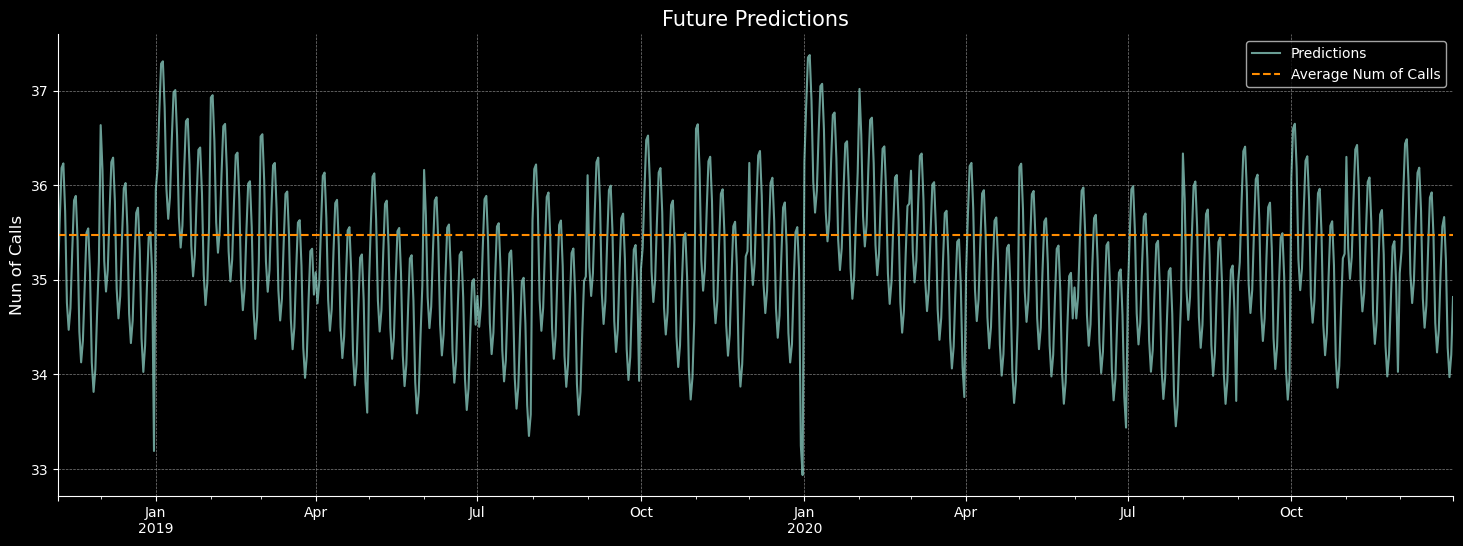

In [62]:
plt.figure(figsize = (18,6))
#Plotting the predictions.
df_future['predictions'].plot(label = 'Predictions',
                         alpha = 0.75)

#Simply plotting the mean number of calls.
plt.axhline(y= df3['Num_Calls'].mean(),
            linestyle = '--',
            label = 'Average Num of Calls',
            color = 'darkorange')

plt.legend()
plt.title('Future Predictions', size = 15)
plt.ylabel('Nun of Calls', size = 12)
    
#Usual styling.
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

^

We can see a curious pattern that the Multi-Layer Perceptron has picked up on here, albeit erroneously - or at least no better than using the average. It seems to predict that the calls jump up at New Year and stay elevated until April, where they appear to dip below the average until October.

It looks like it's consistently predicting a rise and fall in calls each week, which looking back at Step: 1 EDA, we *did* see, but perhaps not so extreme. Let's plot this to confirm.

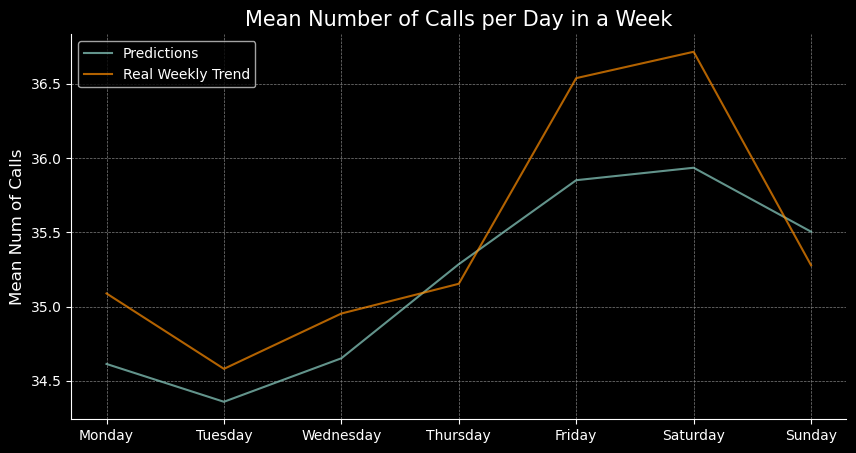

In [76]:
#Plotting the average prediction for a week.
fig, ax = plt.subplots(figsize=(10,5))
df_future['predictions'].groupby(df_future.index.dayofweek).agg(['mean'])\
    .plot(alpha = 0.7,
          legend = False,
          ax = ax)

#Re-plotting the actual observed weekly average.
df2.groupby(df2.index.dayofweek).agg(['mean'])\
    .plot(alpha = 0.7,
          legend = False,
          color = 'darkorange',
          ax=ax)

plt.legend(['Predictions', 'Real Weekly Trend'])
plt.ylabel('Mean Num of Calls', size = 12)
plt.title('Mean Number of Calls per Day in a Week', size= 15)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday',
                      'Thursday', 'Friday', 'Saturday', 'Sunday'])

#Styling.
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

^

Well, we can see that the trend is the same, but the real world is evidently more complicated than this, since even our best model performs unsatisfactorily.

Just for fun, let's write a quick function that takes a future date as an input and returns the predicted result and the mean.

In [77]:
def how_many_calls(date):
    '''
    Prints out the predicted number of calls and
    campares it to the mean.
    
    date = date to predict, yyyy-mm-dd.
    '''
    #Double checking the input is a string.
    date = str(date)
    #Converting to datetime.
    df_pred = pd.DataFrame(index=[pd.to_datetime(date)])
    df_pred = apply_features(df_pred)
    #Getting the prediction.
    prediction = mlp_future.predict(df_pred)
    #Getting the mean.
    mean = df3['Num_Calls'].mean()
    
    if prediction > mean:
        z = 'more'
    else:
        z = 'less'
    
    diff = prediction[0] - mean
    print(f'On {date}:')
    print(f'{prediction[0]:.2f} calls are predicted.')
    print(f'{diff:.2f} {z} than the mean of {mean:.2f}.')
    print()

In [78]:
#Choosing a few random dates to test the function.
random_dates = ['2020-12-30', '2023-07-30',
                '2024-01-01', '2030-06-06']

for date in random_dates:
    how_many_calls(date)

On 2020-12-30:
34.21 calls are predicted.
-1.27 less than the mean of 35.47.

On 2023-07-30:
34.52 calls are predicted.
-0.95 less than the mean of 35.47.

On 2024-01-01:
36.31 calls are predicted.
0.84 more than the mean of 35.47.

On 2030-06-06:
35.52 calls are predicted.
0.04 more than the mean of 35.47.



^

Although our model doesn't predict any better than the mean, we can imagine that using a similar function (with a better model) would enable us to inform someone who works at the fire station how many calls were predicted and therefore how they could optimize their staffing levels.

Finally, before we conclude, using the information learned in the EDA, let's write a function that tells us how many vehicles/ personnel, and of what type, may be needed on a given day. Obviously, we know that our models don't perform well, but this stands as a proof of concept.

In [132]:
def staffing_levels(date):
    '''
    Takes a date and outputs how many staff and 
    of what type will be needed.
    
    date = the date to predict (string) yyyy-mm-dd
    '''
    #Double checking the input is a string.
    date = str(date)
    #Converting to datetime.
    df_pred = pd.DataFrame(index=[pd.to_datetime(date)])
    df_pred = apply_features(df_pred)
    #Getting the prediction.
    prediction = mlp_future.predict(df_pred)
    #Getting the averages found in EDA.
    call_type = df['Call_Type_Group'].value_counts(normalize=True)
    unit_type = df['Unit_Type'].value_counts(normalize=True)
    als = df['ALS_Unit'].value_counts(normalize=True)
    
    #Printing the results.
    print(f'On {date} \n\n-----------')
    
    print('Amount of calls predicted:')
    for i in range(len(call_type)):
        print(f'  {(call_type[i]*prediction)[0]:.2f} {call_type.index[i]} calls')
     
    print('\n----------')
    print('Units needed:')
    for j in range(len(unit_type)):
        if unit_type[j]*prediction > 1:
            print(f'  {(unit_type[j]*prediction)[0]:.2f} {unit_type.index[j]}s')
    
    print('\n----------')
    print('ALS trained units needed:')
    for k in range(len(als)):
        if als.index[k] == True:
            Q = 'ALS trained'
        else:
            Q = 'non-trained'
            
        print(f'  {(als[k]*prediction)[0]:.2f} {Q} staff')

In [135]:
#Example day.
staffing_levels('2023-12-25')

On 2023-12-25 

-----------
Amount of calls predicted:
  16.67 Potentially Life-Threatening calls
  8.29 Alarm calls
  8.03 Non Life-threatening calls
  1.39 Fire calls

----------
Units needed:
  13.26 ENGINEs
  10.60 MEDICs
  3.71 TRUCKs
  2.54 CHIEFs
  2.11 PRIVATEs
  1.18 RESCUE CAPTAINs

----------
ALS trained units needed:
  21.24 ALS trained staff
  13.14 non-trained staff


^

We can see with this small example how a model could help with optimizing the staff levels for a fire department.

# Summary
---

The goal of this report was to use historic call data from the San Francisco Fire Department to attempt to create a Machine Learning model which predicts how many calls will be made on a given day, thereby facilitating in the optimization of staffing levels. Machine Learning algorithms can achieve a plethora of tasks to aid human workers in a wide variety of areas, one such area is predicting future trends in staffing needs. The best model achieved in this report was **not** satisfactory in predicting future trends, in fact, the staffing manager at our fire department would be more successful by simply presuming that all days will have the mean number of calls (35.47 in our dataset).

- In the **EDA** process we found that the average number of calls had risen from 2000 to 2018 by 33% but it was difficult to discern any noticeable and meaningful pattern in our data. With weekly calls varying on average by 1.5 and monthly calls by 3.5, the true number of calls received seemed to be pretty close to random. We saw that most calls were categorized as 'Potentially Life Threatening' and that 70% of all of the units dispatched were either ENGINEs or MEDICs.
- During the **Feature Engineering** stage, we split our data into training and testing sets, giving ourselves three years of data to test and fifteen years to train. We added thirteen time-series features to our datasets including public holidays and trigonometric features to try and capture the cyclical nature of months and weeks, and we found that from 2010, New Years has received at least 31% more calls than the average day.
- While **Machine Learning** we tried five different models, comparing their results numerically on a dataframe and visually on a graph. We noticed from the outset that the models were performing poorly. After scaling our data and spending a lot of time using Grid Search Cross-Fold Validation **none** of our models performed better than constantly predicting the mean number of calls. Our best model was a neural network, a Multi-Layer Perceptron Regressor to be precise, and since neural networks are considered to be 'black box' models, very little can be derived from the complete model, in other words it's not easily understood by humans, and therefore we can't even explain *what* it's using to predict.

Some future predictions were made as a proof of concept. We provided:
- A two-year projection of call numbers, which could be used in a meeting about staffing levels.
- A function to predict how many calls would be received on any given day, which (given a better model) could be used at any point to help the call centre foresee volume.
- A more detailed function that, given a date, returns the predicted number of different types of vehicles needed, what category the call will fall under and how many ALS trained staff will be needed.

# Conclusion
---
In conclusion, while this project aimed to harness Machine Learning to predict fire department call volumes, the journey revealed the inherent challenges in forecasting such unpredictable events. The lack of discernible patterns and the dynamic nature of emergency calls, influenced by various external factors, made it challenging to build a model that outperformed a simplistic mean prediction. The unpredictable and complex nature of emergency services, coupled with the limited historical data of our dataset, highlights the unique challenges faced in forecasting call volumes accurately.

This project serves as a reminder that even advanced Machine Learning models may struggle when faced with inherently unpredictable scenarios, or simply a lack of training data. This project highlights the cruciality of having enough data, the importance of understanding the unique aspects of the domain, and therefore, the vulnerability of Machine Learning as a whole.

In future projects, we could benefit from an exploration of additional external factors and variables that might contribute to call volume fluctuations. Improving the model's robustness may involve collaborating with domain experts, emergency service personnel, and other stakeholders to gain deeper insights into the intricacies of emergency response dynamics. The inclusion of sources such as weather conditions, city events, or even social media trends, could provide valuable insights into the dynamic nature of emergency calls.

As Issac Asimov wrote in his short story, The Last Question: "Insufficient data for meaningful answer".